In [1]:
%cd /content/drive/MyDrive/normalizing-flows
%pwd

/content/drive/MyDrive/normalizing-flows


'/content/drive/MyDrive/normalizing-flows'

# Changing the base distribution of a flow model

This example shows how one can easily change the base distribution with our API.
First, let's look at how the normalizing flow can learn a two moons target distribution with a Gaussian distribution as the base.

In [3]:
import torch
import numpy as np

import normflows as nf

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

from tqdm import tqdm

In [9]:
import warnings
warnings.filterwarnings('ignore')

# Setting up a flow model with a 2D Gaussian base distribution

In [4]:
# Set up model

# Define 2D Gaussian base distribution
base = nf.distributions.base.DiagGaussian(2)

# Define list of flows
num_layers = 32
flows = []
for i in range(num_layers):
    # Neural network with two hidden layers having 64 units each
    # Last layer is initialized by zeros making training more stable
    param_map = nf.nets.MLP([1, 64, 64, 2], init_zeros=True)
    # Add flow layer
    flows.append(nf.flows.AffineCouplingBlock(param_map))
    # Swap dimensions
    flows.append(nf.flows.Permute(2, mode='swap'))

# Construct flow model
model = nf.NormalizingFlow(base, flows)

In [5]:
model

NormalizingFlow(
  (q0): DiagGaussian()
  (flows): ModuleList(
    (0): AffineCouplingBlock(
      (flows): ModuleList(
        (0): Split()
        (1): AffineCoupling(
          (param_map): MLP(
            (net): Sequential(
              (0): Linear(in_features=1, out_features=64, bias=True)
              (1): LeakyReLU(negative_slope=0.0)
              (2): Linear(in_features=64, out_features=64, bias=True)
              (3): LeakyReLU(negative_slope=0.0)
              (4): Linear(in_features=64, out_features=2, bias=True)
            )
          )
        )
        (2): Merge()
      )
    )
    (1): Permute()
    (2): AffineCouplingBlock(
      (flows): ModuleList(
        (0): Split()
        (1): AffineCoupling(
          (param_map): MLP(
            (net): Sequential(
              (0): Linear(in_features=1, out_features=64, bias=True)
              (1): LeakyReLU(negative_slope=0.0)
              (2): Linear(in_features=64, out_features=64, bias=True)
              (3): Le

In [6]:
# Move model on GPU if available
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else "cpu")
model = model.to(device)

In [7]:
# Define target distribution
target = nf.distributions.TwoMoons()

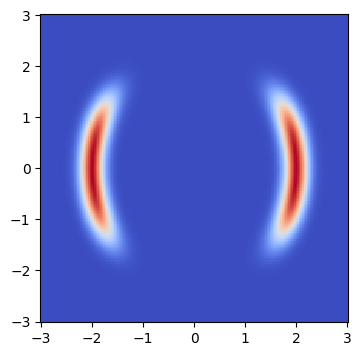

In [10]:
# Plot target distribution
grid_size = 200
xx, yy = torch.meshgrid(torch.linspace(-3, 3, grid_size), torch.linspace(-3, 3, grid_size))
zz = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)
zz = zz.to(device)

log_prob = target.log_prob(zz).to('cpu').view(*xx.shape)
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(4,4))
plt.pcolormesh(xx, yy, prob.data.numpy(), cmap='coolwarm')
plt.gca().set_aspect('equal', 'box')
plt.show()

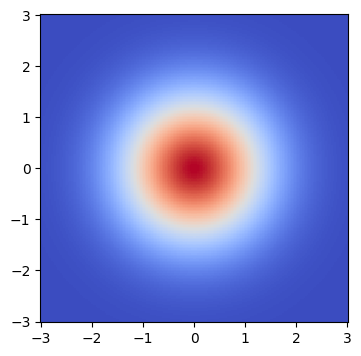

In [11]:
# Plow initial flow distribution
model.eval()
log_prob = model.log_prob(zz).to('cpu').view(*xx.shape)
model.train()
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(4,4))
plt.pcolormesh(xx, yy, prob.data.numpy(), cmap='coolwarm')
plt.gca().set_aspect('equal', 'box')
plt.show()

## Training the model

 12%|█▏        | 499/4000 [00:29<03:26, 16.99it/s]

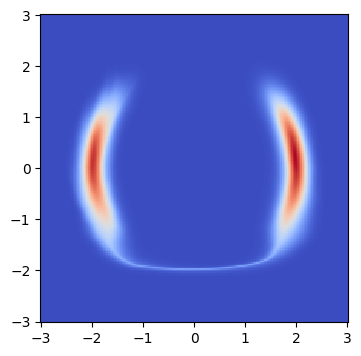

 25%|██▍       | 999/4000 [00:58<02:50, 17.60it/s]

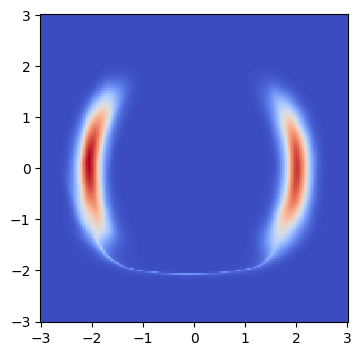

 37%|███▋      | 1499/4000 [01:27<02:25, 17.18it/s]

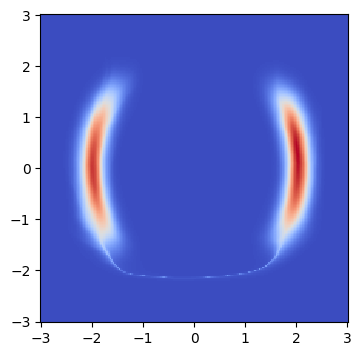

 50%|████▉     | 1999/4000 [01:57<01:59, 16.74it/s]

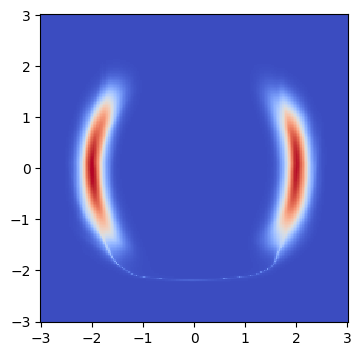

 62%|██████▏   | 2499/4000 [02:26<01:26, 17.39it/s]

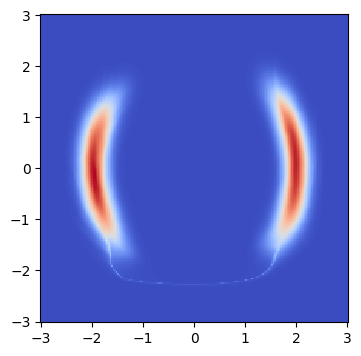

 75%|███████▍  | 2999/4000 [02:55<00:58, 17.18it/s]

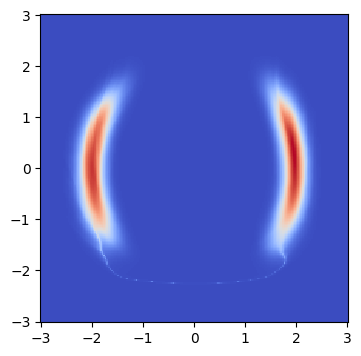

 87%|████████▋ | 3499/4000 [03:25<00:28, 17.29it/s]

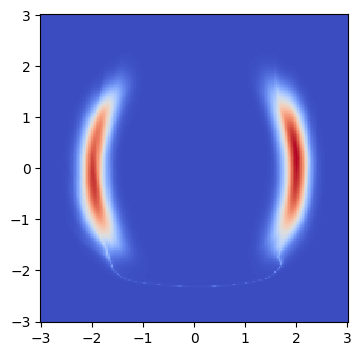

100%|█████████▉| 3999/4000 [03:55<00:00, 17.34it/s]

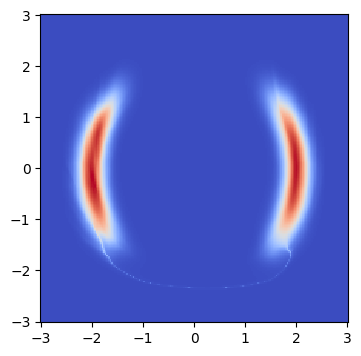

100%|██████████| 4000/4000 [03:55<00:00, 16.98it/s]


In [12]:
# Train model
max_iter = 4000
num_samples = 2 ** 9
show_iter = 500

loss_hist = np.array([])

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)

for it in tqdm(range(max_iter)):
    optimizer.zero_grad()

    # Get training samples
    x = target.sample(num_samples).to(device)

    # Compute loss
    loss = model.forward_kld(x)

    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        optimizer.step()

    # Log loss
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())

    # Plot learned distribution
    if (it + 1) % show_iter == 0:
        model.eval()
        log_prob = model.log_prob(zz)
        model.train()
        prob = torch.exp(log_prob.to('cpu').view(*xx.shape))
        prob[torch.isnan(prob)] = 0

        plt.figure(figsize=(4,4))
        plt.pcolormesh(xx, yy, prob.data.numpy(), cmap='coolwarm')
        plt.gca().set_aspect('equal', 'box')
        plt.show()

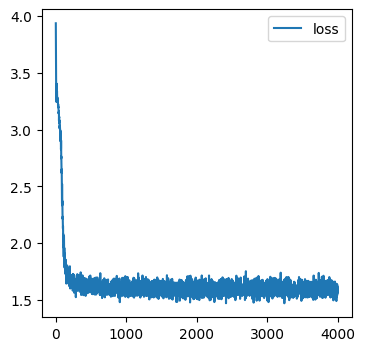

In [14]:
# Plot loss
plt.figure(figsize=(4,4))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

## Visualizing the learned distribution

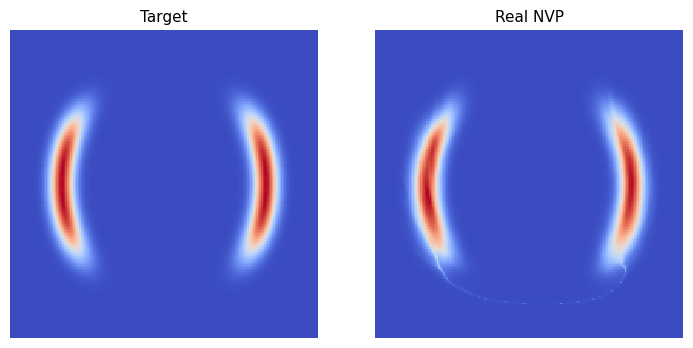

In [15]:
# Plot target distribution
f, ax = plt.subplots(1, 2, sharey=True, figsize=(9, 4))

log_prob = target.log_prob(zz).to('cpu').view(*xx.shape)
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

ax[0].pcolormesh(xx, yy, prob.data.numpy(), cmap='coolwarm')

ax[0].set_aspect('equal', 'box')
ax[0].set_axis_off()
ax[0].set_title('Target', fontsize=11)

# Plot learned distribution
model.eval()
log_prob = model.log_prob(zz).to('cpu').view(*xx.shape)
model.train()
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

ax[1].pcolormesh(xx, yy, prob.data.numpy(), cmap='coolwarm')

ax[1].set_aspect('equal', 'box')
ax[1].set_axis_off()
ax[1].set_title('Real NVP', fontsize=11)

plt.subplots_adjust(wspace=0.1)

plt.show()

Notice there is a bridge between the two modes of the learned target.
This is not a big deal usually since the bridge is really thin, and going to higher dimensional space will make it expoentially unlike to have samples within the bridge.
However, we can see the shape of each mode is also a bit distorted.
So it would be nice to get rid of the bridge. Now let's try to use a Gaussian mixture distribution as our base distribution, instead of a single Gaussian.

# Use a Gaussian mixture model as the base instead

In [16]:
# Set up model

# Define a mixture of Gaussians with 2 modes.
base = nf.distributions.base.GaussianMixture(2, 2, loc=[[-2, 0], [2, 0]], scale=[[0.3, 0.3], [0.3, 0.3]])

# Define list of flows
num_layers = 32
flows = []

for i in range(num_layers):
    # Neural network with two hidden layers having 64 units each
    # Last layer is initialized by zeros making training more stable
    param_map = nf.nets.MLP([1, 64, 64, 2], init_zeros=True)
    # Add flow layer
    flows.append(nf.flows.AffineCouplingBlock(param_map))
    # Swap dimensions
    flows.append(nf.flows.Permute(2, mode='swap'))

# Construct flow model
model = nf.NormalizingFlow(base, flows).cuda()

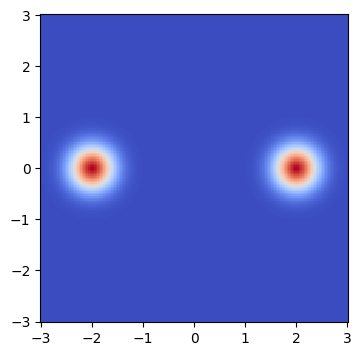

In [17]:
# Plot initial flow distribution
model.eval()
log_prob = model.log_prob(zz).to('cpu').view(*xx.shape)
model.train()
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(4, 4))
plt.pcolormesh(xx, yy, prob.data.numpy(), cmap='coolwarm')
plt.gca().set_aspect('equal', 'box')
plt.show()

## Train the new model

 12%|█▏        | 498/4000 [00:29<03:24, 17.09it/s]

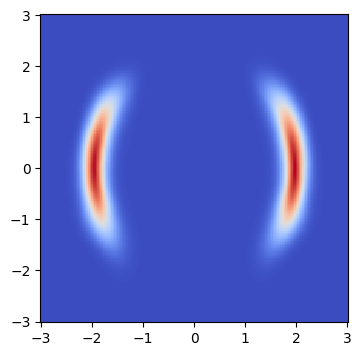

 25%|██▍       | 998/4000 [00:59<03:01, 16.58it/s]

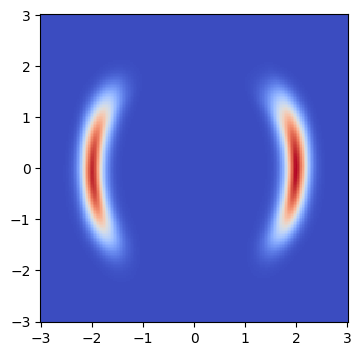

 37%|███▋      | 1498/4000 [01:29<02:32, 16.38it/s]

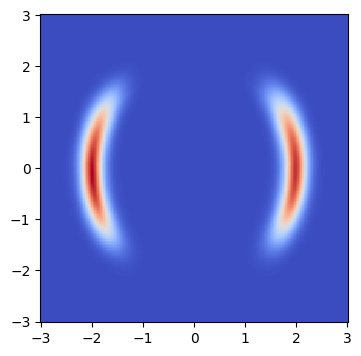

 50%|████▉     | 1998/4000 [01:59<01:58, 16.96it/s]

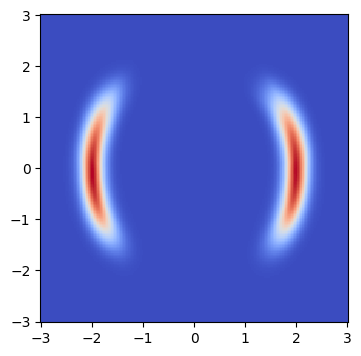

 62%|██████▏   | 2498/4000 [02:29<01:26, 17.38it/s]

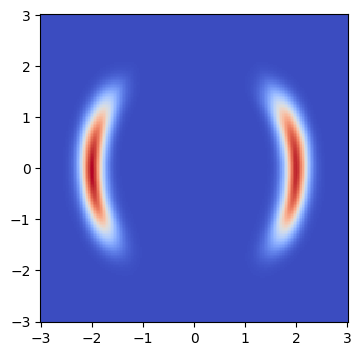

 75%|███████▍  | 2998/4000 [02:59<00:58, 17.27it/s]

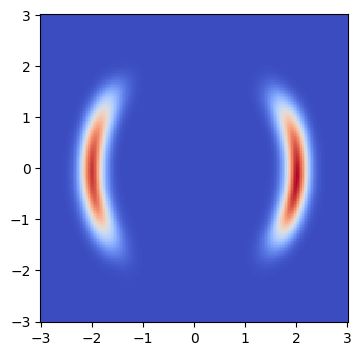

 87%|████████▋ | 3498/4000 [03:28<00:29, 17.26it/s]

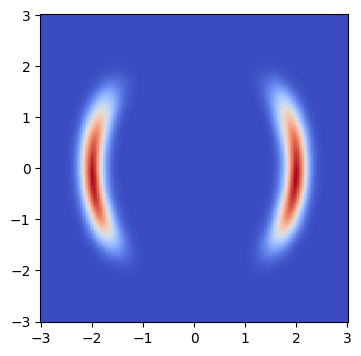

100%|█████████▉| 3998/4000 [03:58<00:00, 16.71it/s]

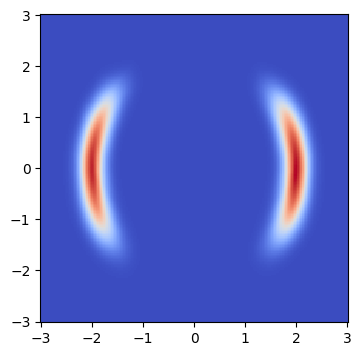

100%|██████████| 4000/4000 [03:58<00:00, 16.76it/s]


In [18]:
# Train model
max_iter = 4000
num_samples = 2 ** 9
show_iter = 500

loss_hist = np.array([])

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)

for it in tqdm(range(max_iter)):
    optimizer.zero_grad()

    # Get training samples
    x = target.sample(num_samples).to(device)

    # Compute loss
    loss = model.forward_kld(x)

    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        optimizer.step()

    # Log loss
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())

    # Plot learned distribution
    if (it + 1) % show_iter == 0:
        model.eval()
        log_prob = model.log_prob(zz)
        model.train()
        prob = torch.exp(log_prob.to('cpu').view(*xx.shape))
        prob[torch.isnan(prob)] = 0

        plt.figure(figsize=(4,4))
        plt.pcolormesh(xx, yy, prob.data.numpy(), cmap='coolwarm')
        plt.gca().set_aspect('equal', 'box')
        plt.show()

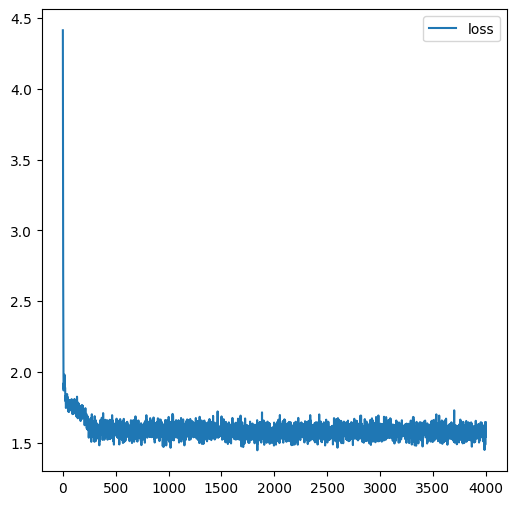

In [19]:
# Plot loss
plt.figure(figsize=(6, 6))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

Now the modes are in better shape! And there is no bridge between the two modes!

# Mixed Circular and Normal Neural Spline Flow

This is a Neural Spline Flow model which has circularand unbounded random variables combined in one random vector.

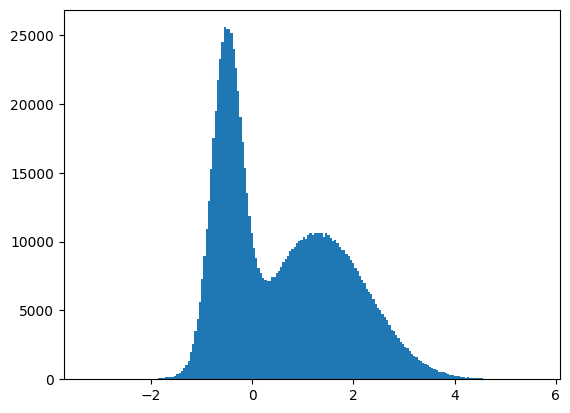

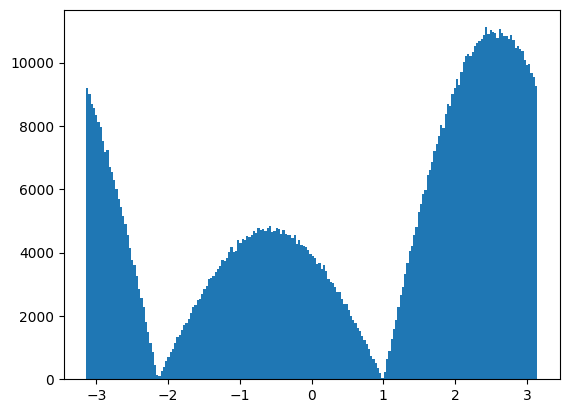

In [20]:
# Set up target
class Target:
    def __init__(self, ndim, ind_circ):
        self.ndim = ndim
        self.ind_circ = ind_circ

    def sample(self, n):
        s = torch.randn(n, self.ndim)
        c = torch.rand(n, self.ndim) > 0.6
        s = c * (0.3 * s - 0.5) + (1 - 1. * c) * (s + 1.3)
        u = torch.rand(n, len(self.ind_circ))
        s_ = torch.acos(2 * u - 1)
        c = torch.rand(n, len(self.ind_circ)) > 0.3
        s_[c] = -s_[c]
        s[:, self.ind_circ] = (s_ + 1) % (2 * np.pi) - np.pi
        return s

# Visualize target
target = Target(2, [1])
s = target.sample(1000000)
plt.hist(s[:, 0].data.numpy(), bins=200)
plt.show()
plt.hist(s[:, 1].data.numpy(), bins=200)
plt.show()

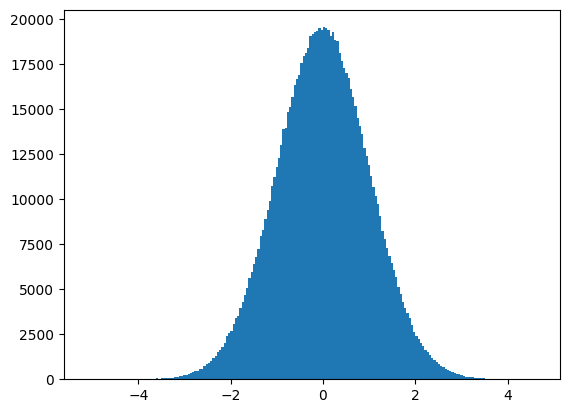

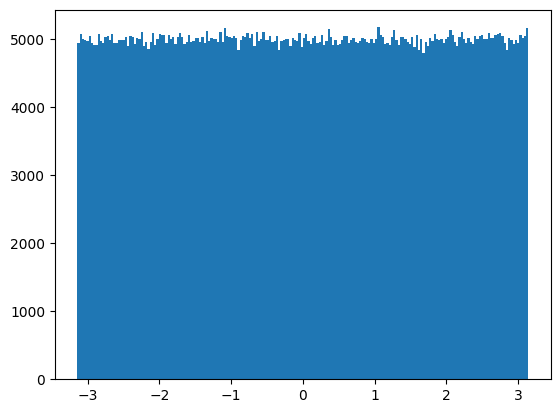

In [21]:
base = nf.distributions.UniformGaussian(2, [1], torch.tensor([1., 2 * np.pi]))

# Visualize base
s = base.sample(1000000)
plt.hist(s[:, 0].data.numpy(), bins=200)
plt.show()
plt.hist(s[:, 1].data.numpy(), bins=200)
plt.show()

In [23]:
# Create normalizing flow
K = 20

flow_layers = []
for i in range(K):
    flow_layers += [nf.flows.CircularAutoregressiveRationalQuadraticSpline(2, 1, 128, [1],
                                                                           tail_bound=torch.tensor([5, np.pi]),
                                                                                                   permute_mask=True)]
model = nf.NormalizingFlow(base, flow_layers)

# Mode model on GPU if available
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else "cpu")
model = model.to(device)

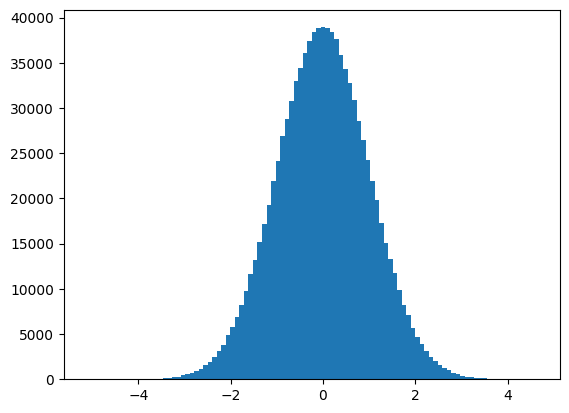

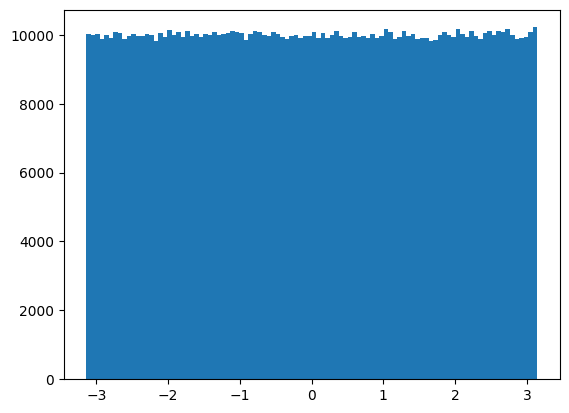

In [24]:
model.eval()
with torch.no_grad():
    x, _ = model.sample(50000)
model.train()
plt.hist(s[:,0].cpu().data.numpy(), bins=100)
plt.show()
plt.hist(s[:,1].cpu().data.numpy(), bins=100)
plt.show()

 25%|██▍       | 4999/20000 [15:32<46:30,  5.38it/s]

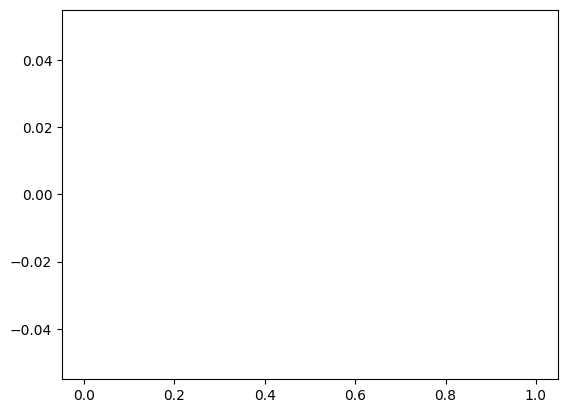

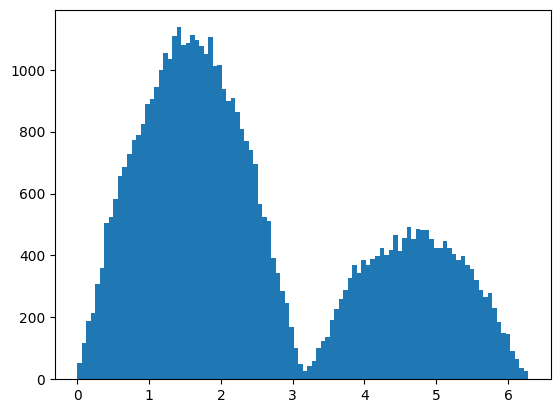

 50%|████▉     | 9999/20000 [31:13<31:33,  5.28it/s]

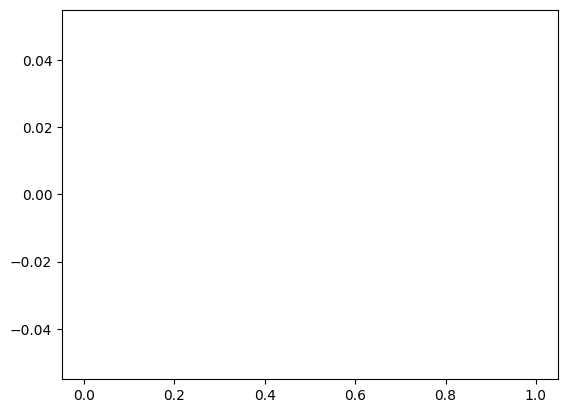

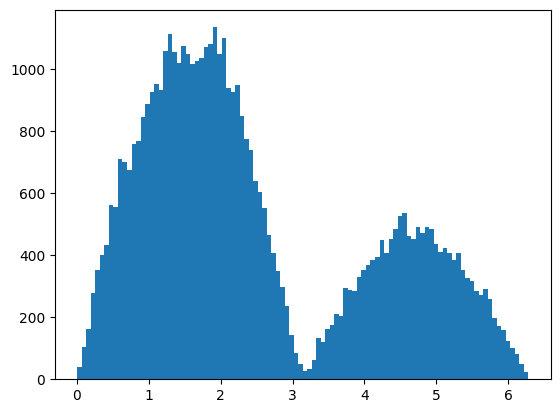

 68%|██████▊   | 13632/20000 [42:34<19:53,  5.34it/s]


KeyboardInterrupt: 

In [25]:
# Train model
max_iter = 20000
num_samples = 2 ** 10
show_iter = 5000

loss_hist = np.array([])

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
for it in tqdm(range(max_iter)):
    optimizer.zero_grad()

    # Get training samples
    x = target.sample(num_samples)

    # Compute loss
    loss = model.forward_kld(x.to(device))

    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        optimizer.step()

    # Log loss
    los_hist = np.append(loss_hist, loss.to('cpu').data.numpy())

    # Plot learned density
    if (it + 1) % show_iter == 0:
        model.eval()
        with torch.no_grad():
            s, _ = model.sample(50000)
        model.train()
        plt.hist(s[: 0].cpu().data.numpy(), bins=100)
        plt.show()
        plt.hist((s[:, 1].cpu().numpy() - 1) % (2 * np.pi), bins=100)
        plt.show()

In [ ]:
# Plot loss
plt.figure(figsize=(4, 4))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

# Comparison of Planar, Radial, and Affine Coupling Flows

In this notebook, we train normalizing flows to fit predefined prior distributions, testing their expressivity. The plots are generated to visualize the learned distributions for given layers $K$, and the training loss is plotted to compare the expressivity of different flows.

In [26]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np

import normflows as nf

from matplotlib import pyplot as plt
from tqdm import tqdm

print("PyTorch version: %s" % torch.__version__)
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Using device: %s" % dev)

#z shape is (batch_size, num_samples, dim)

PyTorch version: 2.5.1+cu121
Using device: cuda


### Prior target distribution visualization

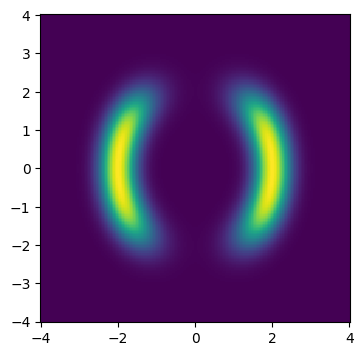

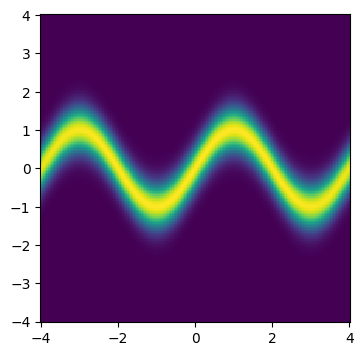

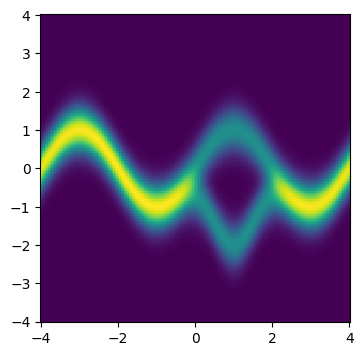

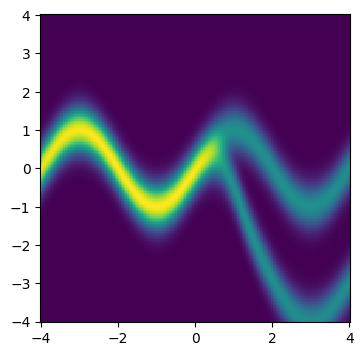

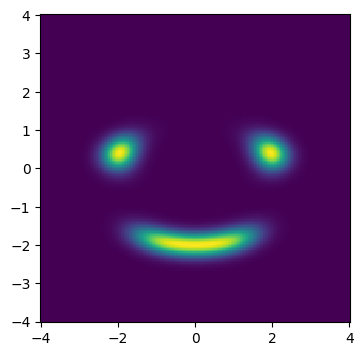

In [28]:
priors = []
priors.append(nf.distributions.TwoModes(2.0, 0.2))
priors.append(nf.distributions.Sinusoidal(0.4, 4))
priors.append(nf.distributions.Sinusoidal_gap(0.4, 4))
priors.append(nf.distributions.Sinusoidal_split(0.4, 4))
priors.append(nf.distributions.Smiley(0.15))

# Plot prior distributions
grid_size=200
grid_length=4.0
grid_shape = ([-grid_length, grid_length], [-grid_length, grid_length])

space_mesh = torch.linspace(-grid_length, grid_length, grid_size)
xx, yy = torch.meshgrid(space_mesh, space_mesh)
z = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2)
z = z.reshape(-1, 2)

for k in range(len(priors)):
    log_prob = priors[k].log_prob(z)
    prob = torch.exp(log_prob)

    plt.figure(figsize=(4,4))
    plt.pcolormesh(xx, yy, prob.reshape(grid_size, grid_size))
    plt.show()

### Flow training

Flow type Planar with K = 2


100%|██████████| 20000/20000 [01:46<00:00, 187.20it/s]


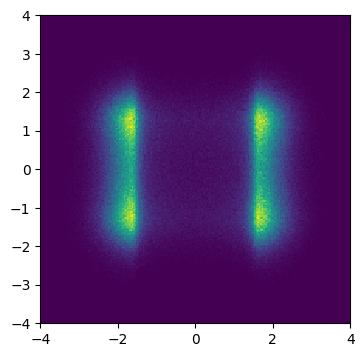

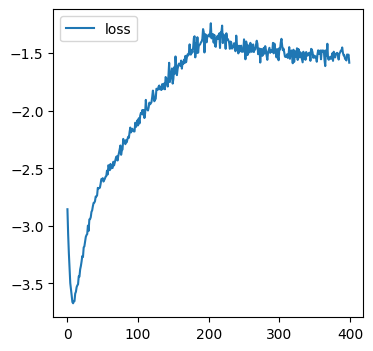

100%|██████████| 20000/20000 [01:44<00:00, 191.77it/s]


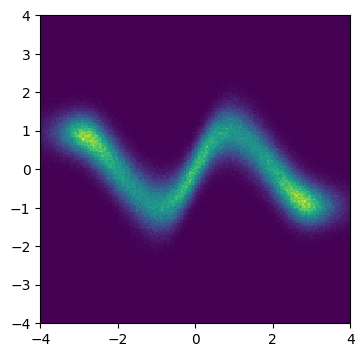

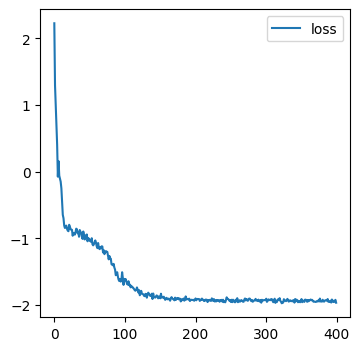

100%|██████████| 20000/20000 [02:02<00:00, 163.39it/s]


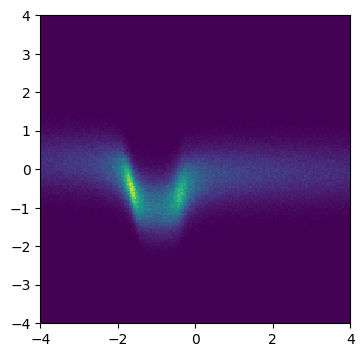

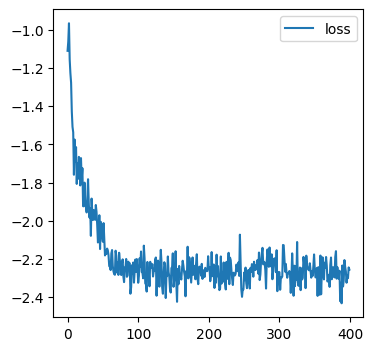

100%|██████████| 20000/20000 [01:59<00:00, 167.44it/s]


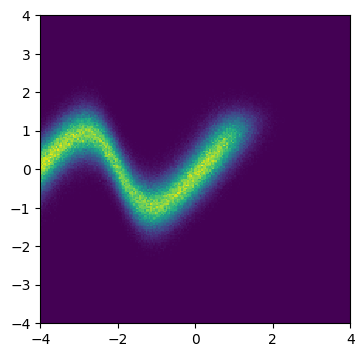

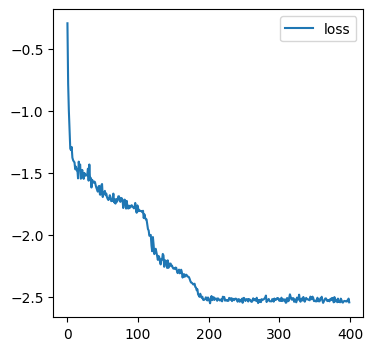

100%|██████████| 20000/20000 [01:42<00:00, 195.74it/s]


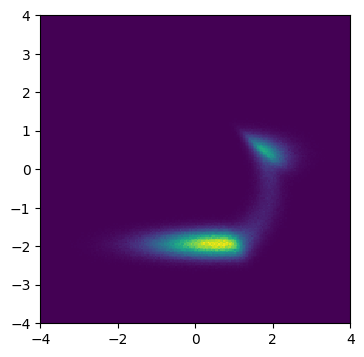

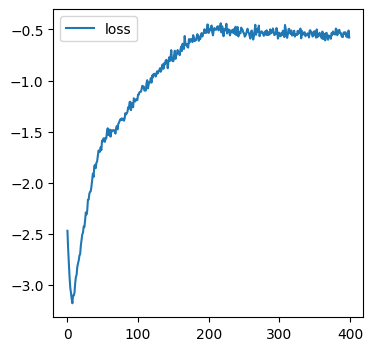

Flow type Planar with K = 8


100%|██████████| 20000/20000 [04:42<00:00, 70.91it/s]


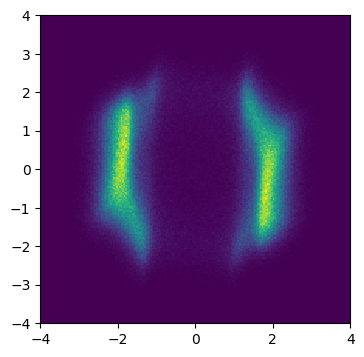

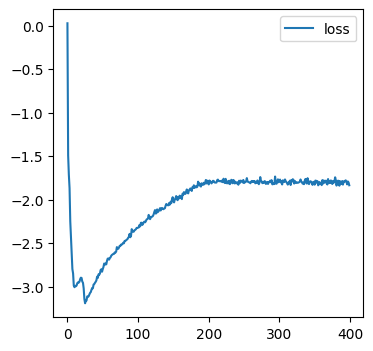

100%|██████████| 20000/20000 [04:29<00:00, 74.17it/s]


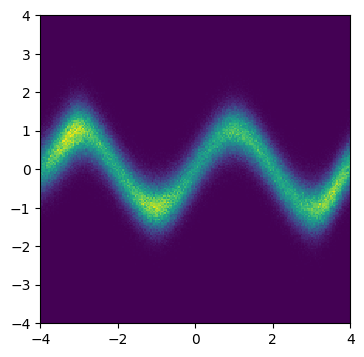

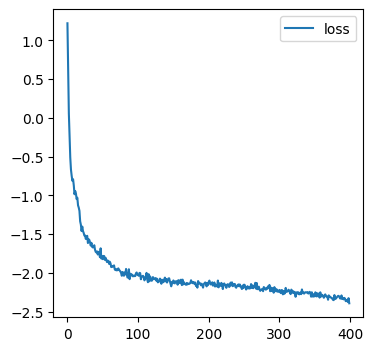

100%|██████████| 20000/20000 [04:48<00:00, 69.28it/s]


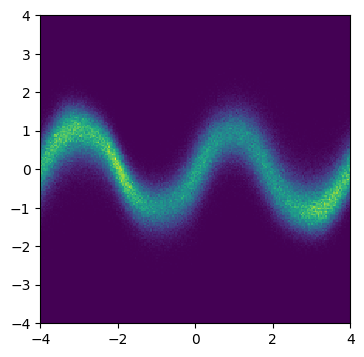

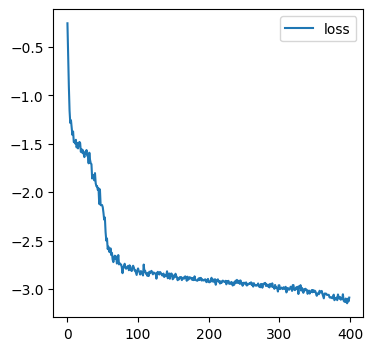

100%|██████████| 20000/20000 [04:44<00:00, 70.31it/s]


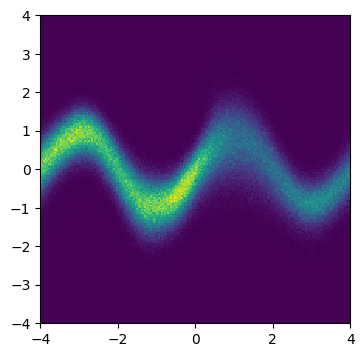

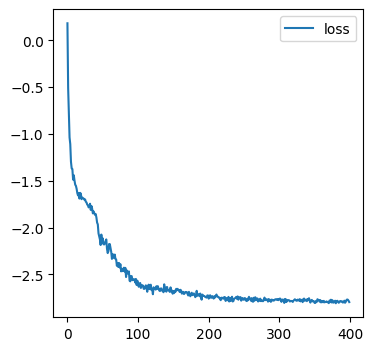

100%|██████████| 20000/20000 [04:31<00:00, 73.73it/s]


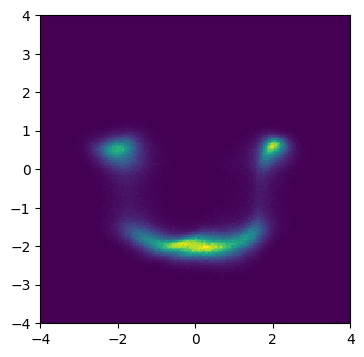

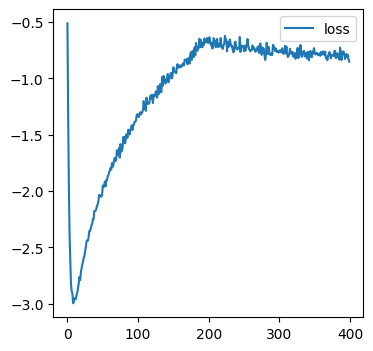

Flow type Planar with K = 32


  1%|▏         | 286/20000 [00:13<15:55, 20.64it/s]


KeyboardInterrupt: 

In [31]:
flow_types = ("Planar", "Radial", "NICE", "RealNVP")
max_iter = 20000
batch_size = 1024
plot_batches = 10 ** 2
plot_samples = 10 ** 4
save_iter = 50

for name in flow_types:
    K_arr = [2, 8, 32]
    for K in K_arr:
        print("Flow type {} with K = {}".format(name, K))
        for k in range(len(priors)):
            if k == 0 or k == 4:
                anneal_iter = 10000
            else: # turn annealing off when fitting to sinusoidal distributions
                anneal_iter = 1

            flows = []
            b = torch.tensor([0,1])
            for i in range(K):
                if name == "Planar":
                    flows += [nf.flows.Planar((2,))]
                elif name == "Radial":
                    flows += [nf.flows.Radial((2,))]
                elif name == "NICE":
                    flows += [nf.flows.MaskedAffineFlow(b, nf.nets.MLP([2, 16, 16, 2], init_zeros=True))]
                elif name == "RealNVP":
                    flows += [nf.flows.MaskedAffineFlow(b, nf.nets.MLP([2, 16, 16, 2], init_zeros=True),
                                                        nf.nets.MLP([2, 16, 16, 2], init_zeros=True))]
                b = 1-b # parity alternation for mask

            q0 = nf.distributions.DiagGaussian(2)
            nfm = nf.NormalizingFlow(p=priors[k], q0=q0, flows=flows)
            nfm.to(dev) # Move model on GPU if available

            # Train model
            loss_hist = np.array([])
            log_q_hist = np.array([])
            log_p_hist = np.array([])
            x = torch.zeros(batch_size, device=dev)

            optimizer = torch.optim.Adam(nfm.parameters(), lr=1e-3, weight_decay=1e-3)
            for it in tqdm(range(max_iter)):
                optimizer.zero_grad()
                loss = nfm.reverse_kld(batch_size, np.min([1.0, 0.01 + it / anneal_iter]))
                if ~(torch.isnan(loss) | torch.isinf(loss)):
                    loss.backward()
                    optimizer.step()

                if (it + 1) % save_iter == 0:
                    loss_hist = np.append(loss_hist, loss.cpu().data.numpy())

            # Plot learned posterior distribution
            z_np = np.zeros((0, 2))
            for i in range(plot_batches):
                z, _ = nfm.sample(plot_samples)
                z_np = np.concatenate((z_np, z.cpu().data.numpy()))
            plt.figure(figsize=(4, 4))
            plt.hist2d(z_np[:, 0], z_np[:, 1], (grid_size, grid_size), grid_shape)
            plt.show()
            # np.save("{}-K={}-k={}".format(name,K,k), (z_np, loss.cpu().data.numpy()))

            # Plot training history
            plt.figure(figsize=(4, 4))
            plt.plot(loss_hist, label='loss')
            plt.legend()
            plt.show()

### Expressivity plot of flows

In [ ]:
fig = plt.figure(figsize=(9, 6))
K_arr = [2, 8, 32]
nrows=5
ncols=7
axes = [ fig.add_subplot(nrows, ncols, r * ncols + c + 1) for r in range(0, nrows) for c in range(0, ncols) ]

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

grid_size = 100
grid_length = 4.0
grid_shape = ([-grid_length, grid_length], [-grid_length, grid_length])

space_mesh = torch.linspace(-grid_length, grid_length, grid_size)
xx, yy = torch.meshgrid(space_mesh, space_mesh)
z = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2)
z = z.reshape(-1, 2)
axes[0].annotate('Target', xy=(0.5, 1.10), xytext=(0.5, 1.20), xycoords='axes fraction',
            fontsize=24, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1.5, lengthB=0.2', lw=2.0))
for k in range(5):
    axes[k*ncols].set_ylabel('{}'.format(k+1), rotation=0, fontsize=20, labelpad=15)
    log_prob = priors[k].log_prob(z)
    prob = torch.exp(log_prob)
    axes[k*ncols + 0].pcolormesh(xx, yy, prob.reshape(grid_size, grid_size))


for l in range(len(K_arr)):
    K = K_arr[l]
    if l == 1:
        axes[0*ncols + l+1].annotate('Planar flows', xy=(0.5, 1.10), xytext=(0.5, 1.20), xycoords='axes fraction',
            fontsize=24, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=6.0, lengthB=0.2', lw=2.0))
    axes[4*ncols + l+1].set_xlabel('K = {}'.format(K), fontsize=20)
    for k in range(5):
        z_np, _ = np.load("Planar-K={}-k={}.npy".format(K,k), allow_pickle=True)
        axes[k*ncols + l+1].hist2d(z_np[:, 0], z_np[:, 1], (grid_size, grid_size), grid_shape)

for l in range(len(K_arr)):
    K = K_arr[l]
    if l == 1:
        axes[0*ncols + l+1+len(K_arr)].annotate('Radial flows', xy=(0.5, 1.10), xytext=(0.5, 1.20), xycoords='axes fraction',
            fontsize=24, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=6.0, lengthB=0.2', lw=2.0))
    axes[4*ncols + l+1+len(K_arr)].set_xlabel('K = {}'.format(K), fontsize=20)
    for k in range(5):
        z_np, _ = np.load("Radial-K={}-k={}.npy".format(K,k), allow_pickle=True)
        axes[k*ncols + l+1+len(K_arr)].hist2d(z_np[:, 0], z_np[:, 1], (grid_size, grid_size), grid_shape)

fig.subplots_adjust(hspace=0.02, wspace=0.02)

for l in range(1,4):
    for k in range(5):
        pos1 = axes[k*ncols + l].get_position() # get the original position
        pos2 = [pos1.x0 + 0.01, pos1.y0,  pos1.width, pos1.height]
        axes[k*ncols + l].set_position(pos2) # set a new position

for l in range(4,7):
    for k in range(5):
        pos1 = axes[k*ncols + l].get_position() # get the original position
        pos2 = [pos1.x0 + 0.02, pos1.y0,  pos1.width, pos1.height]
        axes[k*ncols + l].set_position(pos2) # set a new position

### Comparison of Planar, Radial,  and Affine on given prior distribution

In [ ]:
from itertools import repeat

k_arr = [0, 2, 4]
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 4))
markers = ['s', 'o', 'v', 'P', 'd']

for k in range(len(k_arr)):
    loss = [[] for i in repeat(None, len(flow_types))]
    for intt, name in enumerate(flow_types):
        for K in K_arr:
            _, loss_v = np.load("{}-K={}-k={}.npy".format(name,K,k), allow_pickle=True)
            loss[intt].append(loss_v)
        axes[k].plot(K_arr, loss[intt], marker=markers[intt], label=name)
    axes[k].set_title('Target {}'.format(k_arr[k]+1), fontsize=16)
    axes[k].set_xlabel('Flow length', fontsize=12)
    axes[k].set_ylabel('Variational bound (nats)', fontsize=12)
    axes[k].legend()
    axes[k].grid('major')

fig.tight_layout(pad=2.0)

# Conditional Normalizing Flow Model

Here, we train a conditional normalizing flow model $q(x|c)$. Our target $p(x|c)$ is a simple 2D Gaussian $\mathcal{N}(x|\mu, \sigma)$, where we condition on the mean $\mu$ and standard deviation $\sigma$, i.e. $c = (\mu, \sigma)$. We apply conditional autoregressive and coupling neural spline flows as well as a conditional masked autoregressive flow to the problem.

## Setup

In [ ]:
# Define target
target = nf.distributions.target.ConditionalDiagGaussian()
context_size = 4

# Plot target
grid_size = 100
xx, yy = torch.meshgrid(torch.linspace(-2, 2, grid_size), torch.linspace(-2, 2, grid_size), indexing='ij')
zz = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)
zz = zz.to(device)
context_plot = torch.cat([torch.tensor([0.3, 0.9]).to(device) + torch.zeros_like(zz),
                          0.6 * torch.ones_like(zz)], dim=-1)
logp = target.log_prob(zz, context_plot)
p_target = torch.exp(logp).view(*xx.shape).cpu().data.numpy()

plt.figure(figsize=(4, 4))
plt.pcolormesh(xx, yy, p_target, shading='auto')
plt.gca().set_aspect('equal', 'box')
plt.show()

## Autoregressive Neural Spline Flow

### Model specification

In [ ]:
# Define flows
K = 4

latent_size = 2
hidden_units = 128
hidden_layers = 2

flows = []
for i in range(K):
    flows += [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, hidden_units,
                                                             num_context_channels=context_size)]
    flows += [nf.flows.LULinearPermute(latent_size)]

# Set base distribution
q0 = nf.distributions.DiagGaussian(2, trainable=False)

# Construct flow model
model = nf.ConditionalNormalizingFlow(q0, flows, target)

# Move model on GPU if available
model = model.to(device)

In [ ]:
# Plot initial flow distribution, target as contours
model.eval()
log_prob = model.log_prob(zz, context_plot).to('cpu').view(*xx.shape)
model.train()
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(4, 4))
plt.pcolormesh(xx, yy, prob.data.numpy(), shading='auto')
plt.contour(xx, yy, p_target, cmap=plt.get_cmap('cool'), linewidths=2)
plt.gca().set_aspect('equal', 'box')
plt.show()

### Training

In [ ]:
# Train model
max_iter = 5000
batch_size = 128

loss_hist = np.array([])

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)

for it in tqdm(range(max_iter)):
    optimizer.zero_grad()

    # Get training samples
    context = torch.cat([torch.randn((batch_size, 2), device=device),
                         0.5 + 0.5 * torch.rand((batch_size, 2), device=device)],
                        dim=-1)
    x = target.sample(batch_size, context)

    # Compute loss
    loss = model.forward_kld(x, context)

    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        optimizer.step()

    # Log loss
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())

# Plot loss
plt.figure(figsize=(4, 4))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

### Evaluation

In [ ]:
# Plot trained flow distribution, target as contours
model.eval()
log_prob = model.log_prob(zz, context_plot).to('cpu').view(*xx.shape)
model.train()
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(4, 4))
plt.pcolormesh(xx, yy, prob.data.numpy(), shading='auto')
plt.contour(xx, yy, p_target, cmap=plt.get_cmap('cool'), linewidths=2)
plt.gca().set_aspect('equal', 'box')
plt.show()

## Coupling Neural Spline Flow

### Model specification

In [ ]:
# Define flows
K = 4

latent_size = 2
hidden_units = 128
hidden_layers = 2

flows = []
for i in range(K):
    flows += [nf.flows.CoupledRationalQuadraticSpline(latent_size, hidden_layers, hidden_units,
                                                      num_context_channels=context_size)]
    flows += [nf.flows.LUlinearPermute(latent_size)]

# Set base distribution
q0 = nf.distributions.DiagGaussian(2, trainable=False)

# Construct flow model
model = nf.ConditionalNormalizingFlow(q0, flows, target)

# Move model on GPU if available
model = model.to(device)

In [ ]:
# Plot initial flow distribution, target as contours
model.eval()
log_prob = model.log_prob(zz, context_plot).to('cpu').view(*xx.shape)
model.train()
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(4, 4))
plt.pcolormesh(xx, yy, prob.data.numpy(), shading='auto')
plt.contour(xx, yy, p_target, cmap=plt.get_cmap('cool'), linewidths=2)
plt.gca().set_aspect('equal', 'box')
plt.show()

### Training

In [ ]:
# Train model
max_iter = 5000
batch_size= 128

loss_hist = np.array([])

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)


for it in tqdm(range(max_iter)):
    optimizer.zero_grad()

    # Get training samples
    context = torch.cat([torch.randn((batch_size, 2), device=device),
                         0.5 + 0.5 * torch.rand((batch_size, 2), device=device)],
                        dim=-1)
    x = target.sample(batch_size, context)

    # Compute loss
    loss = model.forward_kld(x, context)

    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        optimizer.step()

    # Log loss
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())

# Plot loss
plt.figure(figsize=(4, 4))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

### Evaluation

In [ ]:
# Plot trained flow distribution, target as contours
model.eval()
log_prob = model.log_prob(zz, context_plot).to('cpu').view(*xx.shape)
model.train()
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(4, 4))
plt.pcolormesh(xx, yy, prob.data.numpy(), shading='auto')
plt.contour(xx, yy, p_target, cmap=plt.get_cmap('cool'), linewidths=2)
plt.gca().set_aspect('equal', 'box')
plt.show()

## Masked Autoregressive Flow

### Model specification

In [ ]:
# Define flows
K = 4

latent_size=2
hidden_units=128
num_blocks=2

flows = []
for i in range(K):
    flows += [nf.flows.MaskedAffineAutoregressive(latent_size, hidden_units,
                                                  context_features=context_size,
                                                  num_blocks=num_blocks)]
    flows += [nf.flows.LULinearPermute(latent_size)]

# Set base distribution
q0 = nf.distributions.DiagGaussian(2, trainable=False)

# Construct flow model
model = nf.ConditionalNormalizingFlow(q0, flows, target)

# Move model on GPU if available
model = model.to(device)

In [ ]:
# Plot initial flow distribution, target as contours
model.eval()
log_prob = model.log_prob(zz, context_plot).to('cpu').view(*xx.shape)
model.train()
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(4, 4))
plt.pcolormesh(xx, yy, prob.data.numpy(), shading='auto')
plt.contour(xx, yy, p_target, cmap=plt.get_cmap('cool'), linewidths=2)
plt.gca().set_aspect('equal', 'box')
plt.show()

### Training

In [ ]:
# Train model
max_iter = 5000
batch_size= 128

loss_hist = np.array([])

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

for it in tqdm(range(max_iter)):
    optimizer.zero_grad()

    # Get training samples
    context = torch.cat([torch.randn((batch_size, 2), device=device),
                         0.5 + 0.5 * torch.rand((batch_size, 2), device=device)],
                        dim=-1)
    x = target.sample(batch_size, context)

    # Compute loss
    loss = model.forward_kld(x, context)

    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        optimizer.step()

    # Log loss
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())

# Plot loss
plt.figure(figsize=(4, 4))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

### Evaluation

In [ ]:
# Plot trained flow distribution, target as contours
model.eval()
log_prob = model.log_prob(zz, context_plot).to('cpu').view(*xx.shape)
model.train()
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(4, 4))
plt.pcolormesh(xx, yy, prob.data.numpy(), shading='auto')
plt.contour(xx, yy, p_target, cmap=plt.get_cmap('cool'), linewidths=2)
plt.gca().set_aspect('equal', 'box')
plt.show()

# Image generation with Glow

Here, we show how a flow can be trained to generate images with the `normflows` package. The flow is a class-conditional [Glow](https://arxiv.org/abs/1807.03039) model, which is based on the [multi-scale architecture](https://arxiv.org/abs/1605.08803). This Glow model is applied to the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).

## Preparation

In [ ]:
# Import required packages
import torch
import torchvision as tv
import numpy as np
import normflows as nf

from matplotlib import pyplot as plt
from tqdm import tqdm

Now that we imported the necessary packages, we create a flow model. Glow consists of `nf.flows.GlowBlocks`, that are arranged in a `nf.MultiscaleFlow`, following the multi-scale architecture. The base distribution is a `nf.distributions.ClassCondDiagGaussian`, which is a diagonal Gaussian with mean and standard deviation dependent on the class label of the image.

In [ ]:
# Set up model

# Define flows
L = 3
K = 16
torch.manual_seed(0)

input_shape = (3, 32, 32)
n_dims = np.prod(input_shape)
channels=3
hidden_channels=256
split_mode='channel'
scale=True
num_classes = 10

# Set up flows, distributions and merge operations
q0 = []
merges = []
flows = []
for i in range(L):
    flows_ = []
    for j in range(K):
        flows_ += [nf.flows.GlowBlock(channels * 2 ** (L + 1 - i), hidden_channels,
                                      split_mode=split_mode, scale=scale)]
        flows_ += [nf.flows.Squeeze()]
        flows += [flows_]
        if i > 0:
            merges += [nf.flows.Merge()]
            latent_shape = (input_shape[0] * 2 ** (L - i), input_shape[1] // 2 ** (L - i),
                            input_shape[2] // 2 ** (L - i))
        else:
            latent_shape = (input_shape[0] * 2 ** (L + 1), input_shape[1] // 2 ** L,
                            input_shape[2] // 2 ** L)
        q0 += [nf.distributions.ClassCondDiagGaussian(latent_shape, num_classes)]

# Construct flow model with the multiscale architecture
model = nf.MultiscaleFlow(q0, flows, merges)

In [ ]:
# Move model on GPU if available
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')
model = model.to(device)

With `torchvision` we can download the CIFAR-10 dataset.

In [ ]:
# Prepare training data
batch_size = 128

transform = tv.transforms.Compose([tv.transforms.ToTensor(), nf.utils.Scale(255. / 256.), nf.utils.Jitter(1 / 256.)])

train_data = tv.datasets.CIFAR10('dataset/', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)

test_data = tv.datasets.CIFAR10('dataset/', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

train_iter = iter(train_loader)

## Training

Now, can train the model on the image data.

In [ ]:
# Train model
max_iter = 20000

loss_hist = np.array([])

optimizer = torch.optim.Adamax(model.parameters(), lr=1e-3, weight_decay=1e-5)

for i in tqdm(range(max_iter)):
    try:
        x, y = next(train_iter)
    except StopIteration:
        train_iter = iter(train_loader)
        x, y = next(train_iter)
    optimizer.zero_grad()
    loss = model.forward_kld(x.to(device), y.to(device))

    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        optimizer.step()

    loss_hist = np.append(loss_hist, loss.detach().to('cpu').numpy())

In [ ]:
plt.figure(figsize=(4, 4))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

## Evaluation

To evaluate our model, we first draw samples from our model. When sampling, we can specify the classes, so we draw then samples from each class.

In [ ]:
# Model samples
num_sample = 10

with torch.no_grad():
    y = torch.arange(num_classes).repeat(num_sample).to(device)
    x, _ = model.sample(y=y)
    x_ = torch.clamp(x, 0, 1)
    plt.figure(figsize=(4,4))
    plt.imshow(np.transpose(tv.utils.make_grid(x_, nrow=num_classes).cpu().numpy(), (1, 2, 0)))
    plt.show()

For quantitative evaluation, we can compute the bits per dim of our model.

In [ ]:
# Get bits per dim
n = 0
bpd_cum = 0
with torch.no_grad():
    for x, y in iter(test_loader):
        nll = model(x.to(device), y.to(device))
        nll_np = nll.cpu().numpy()
        bpd_cum += np.nansum(nll_np / np.log(2) / n_dims + 8)
        n += len(x) - np.sum(np.isnan(nll_np))

    print('Bits per dim:', bpd_cum / n)

Note that to get competitive performance, a much larger model then specified in this notebook, which is trained over 100 thousand to 1 million iterations, is needed.